Let's start by setting up the annealing of a 1D Ising chain for a small number of spins, periodic boundary conditions and uniform coupling, and check that the ground state is correct:

In [2]:
J_val = 1 # Coupling
N = 10 # Number of spins

# Construct dictionaries for qubit biases and couplers:
h = {} # No biases needed
J = {} # Coupler dictionary
for i in range(N):
    key_tuple = ('s{}'.format(i), 's{}'.format((i + 1) % N))
    J[key_tuple] = J_val

print(J)

{('s0', 's1'): 1, ('s1', 's2'): 1, ('s2', 's3'): 1, ('s3', 's4'): 1, ('s4', 's5'): 1, ('s5', 's6'): 1, ('s6', 's7'): 1, ('s7', 's8'): 1, ('s8', 's9'): 1, ('s9', 's0'): 1}


Next, we anneal the problem we set up above:

In [3]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler()) # Sampler to use, with auto-embedding

samples = sampler.sample_ising(h, J, num_reads = 1, label='Anneal a small spin chain as a test') # Do a single anneal
print(samples)

  s0 s1 s2 s3 s4 s5 s6 s7 s8 s9 energy num_oc. chain_.
0 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1  -10.0       1     0.0
['SPIN', 1 rows, 1 samples, 10 variables]


Let's wrap this into a function and check the effect for different couplings:

In [4]:
def anneal_1d_chain(J_val, N):
    # Construct dictionaries for qubit biases and couplers:
    h = {} # No biases needed
    J = {} # Coupler dictionary
    for i in range(N):
        key_tuple = ('s{}'.format(i), 's{}'.format((i + 1) % N))
        J[key_tuple] = J_val
    sampler = EmbeddingComposite(DWaveSampler()) # Sampler to use, with auto-embedding
    samples = sampler.sample_ising(h, J, num_reads = 1, label='Anneal a small spin chain as a test') # Do a single anneal

    return samples

print(anneal_1d_chain(1, N))
print(anneal_1d_chain(-1, N))

  s0 s1 s2 s3 s4 s5 s6 s7 s8 s9 energy num_oc. chain_.
0 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1  -10.0       1     0.0
['SPIN', 1 rows, 1 samples, 10 variables]
  s0 s1 s2 s3 s4 s5 s6 s7 s8 s9 energy num_oc. chain_.
0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -10.0       1     0.0
['SPIN', 1 rows, 1 samples, 10 variables]


Next, we need to control the annealing time to control the formation of defects (kinks), so we change the function to allow this:

In [5]:
def anneal_1d_chain(J_val, N, ta):
    # Construct dictionaries for qubit biases and couplers:
    h = {} # No biases needed
    J = {} # Coupler dictionary
    for i in range(N):
        key_tuple = ('s{}'.format(i), 's{}'.format((i + 1) % N))
        J[key_tuple] = J_val
    sampler = EmbeddingComposite(DWaveSampler()) # Sampler to use, with auto-embedding
    samples = sampler.sample_ising(h, J, num_reads = 1, label='Anneal a small spin chain as a test', annealing_time=ta) # Do a single anneal

    return samples

print(anneal_1d_chain(1, N, 0.5))
print(anneal_1d_chain(1, N, 1))
print(anneal_1d_chain(1, N, 20))
print(anneal_1d_chain(1, N, 50))

  s0 s1 s2 s3 s4 s5 s6 s7 s8 s9 energy num_oc. chain_.
0 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1  -10.0       1     0.0
['SPIN', 1 rows, 1 samples, 10 variables]
  s0 s1 s2 s3 s4 s5 s6 s7 s8 s9 energy num_oc. chain_.
0 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1  -10.0       1     0.0
['SPIN', 1 rows, 1 samples, 10 variables]
  s0 s1 s2 s3 s4 s5 s6 s7 s8 s9 energy num_oc. chain_.
0 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1  -10.0       1     0.0
['SPIN', 1 rows, 1 samples, 10 variables]
  s0 s1 s2 s3 s4 s5 s6 s7 s8 s9 energy num_oc. chain_.
0 +1 -1 +1 -1 +1 -1 +1 -1 -1 -1   -6.0       1     0.0
['SPIN', 1 rows, 1 samples, 10 variables]


There isn't obviously any change in terms of kinks etc. here, but we are using short chains and quite different anneal times relative to some results in the paper where they go as short as a few ns to get to the KZ regime. With these anneal times we are very much in the adiabatic anti KZM regime. Let's check what range of anneal times is possible:

In [6]:
test_sampler = DWaveSampler()
print(test_sampler.properties['default_annealing_time'])
print(test_sampler.properties['annealing_time_range'])

20.0
[0.5, 2000.0]


We therefore cannot access the short anneal times used in the paper, or not obviously at least. Let's look more systematically at the effect of chain size, anneal time and coupler strength to get some intuition for how things look. Note that the annealing schedules (general shape, typical energy etc.) are similar between this machine and the paper. First, we'll set up a function to visualise the spin chain with periodic boundary conditions:

  s0 s1 s10 s100 s101 s102 s103 s104 s105 s106 s107 ... s99 energy num_oc. ...
0 -1 +1  -1   -1   +1   -1   +1   -1   +1   -1   +1 ...  +1 -452.0       1 ...
['SPIN', 1 rows, 1 samples, 512 variables]


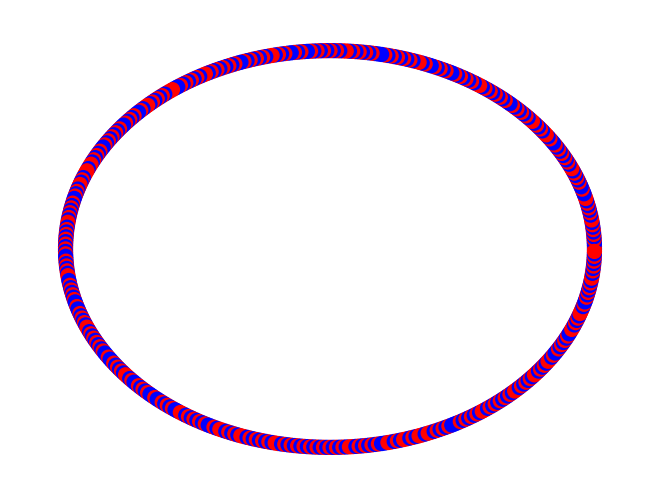

In [7]:
import networkx as nx # For drawing graphs
import matplotlib.pyplot as plt

N = 512 # Use a long chain
long_chain = anneal_1d_chain(J_val, N, 0.5)
print(long_chain)
spins = long_chain.record[0][0]

def draw_chain(N, spins):
    plt.figure()
    G = nx.Graph()
    G.add_nodes_from(range(N), spin=spins) # Add spins to graph
    for i in range(N):
        G.add_edge(i, (i + 1) % N)

    nx.draw_circular(G, cmap=plt.get_cmap('bwr'), node_color=spins, node_size=100)

draw_chain(N, spins)

Let's now see the effect of changing the anneal time:

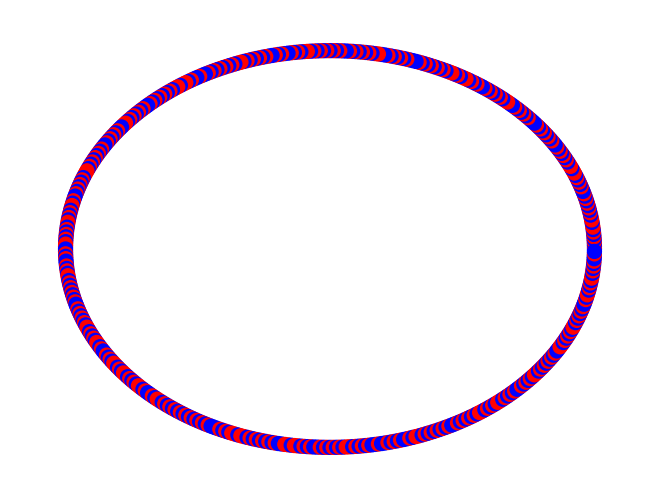

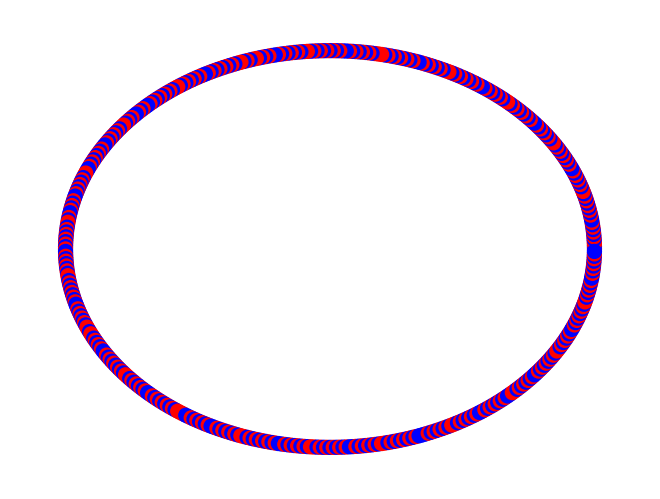

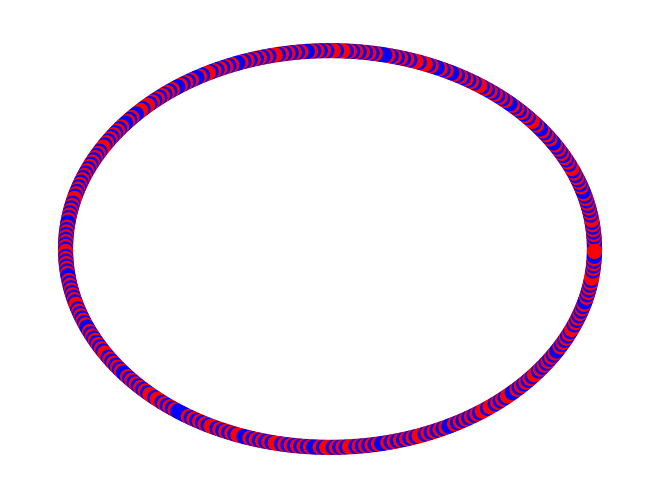

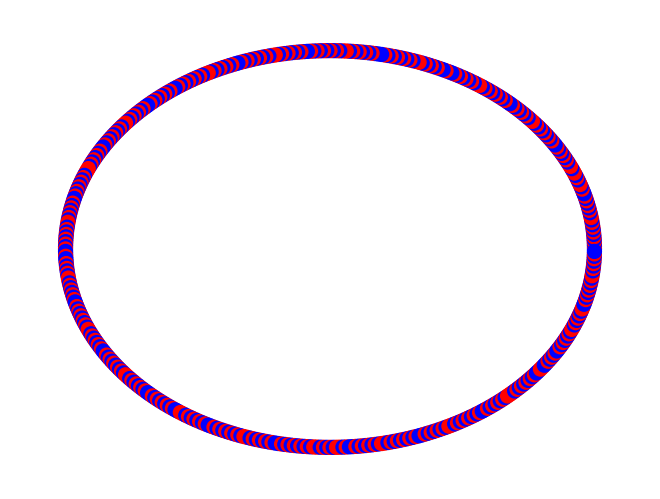

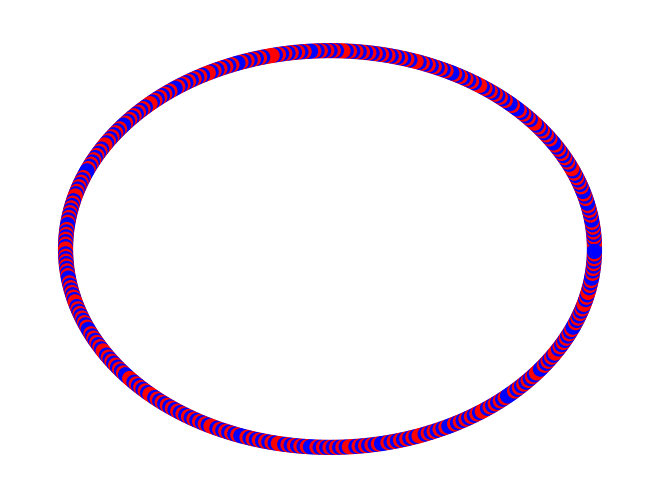

In [8]:
long_chain = anneal_1d_chain(J_val, N, 0.5)
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(J_val, N, 20) # Default anneal time
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(J_val, N, 100)
spins = long_chain.record[0][0] 
draw_chain(N, spins)

long_chain = anneal_1d_chain(J_val, N, 500)
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(J_val, N, 2000)
spins = long_chain.record[0][0]
draw_chain(N, spins)

Qualitatively these all look pretty similar. Let's also vary the coupler strength:

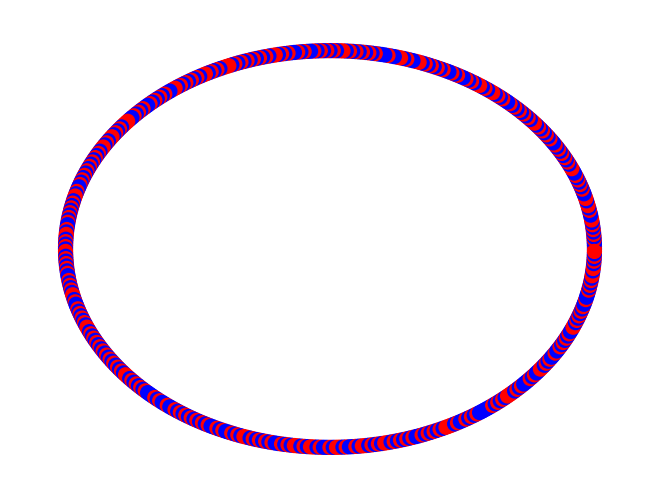

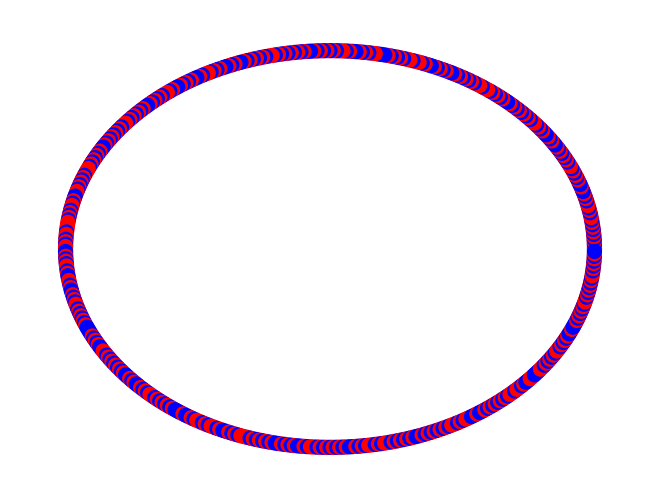

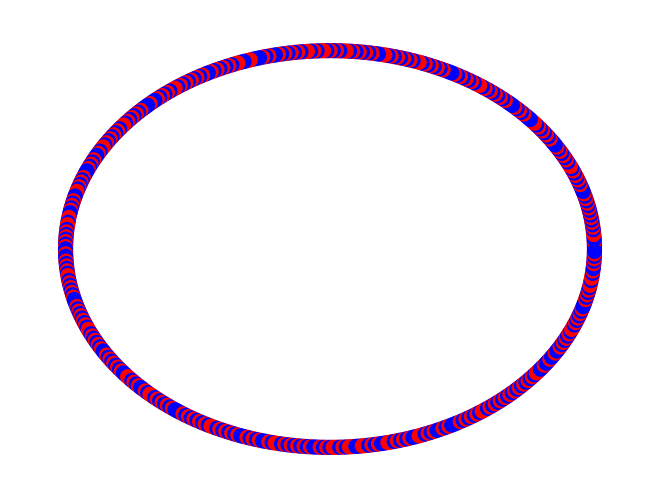

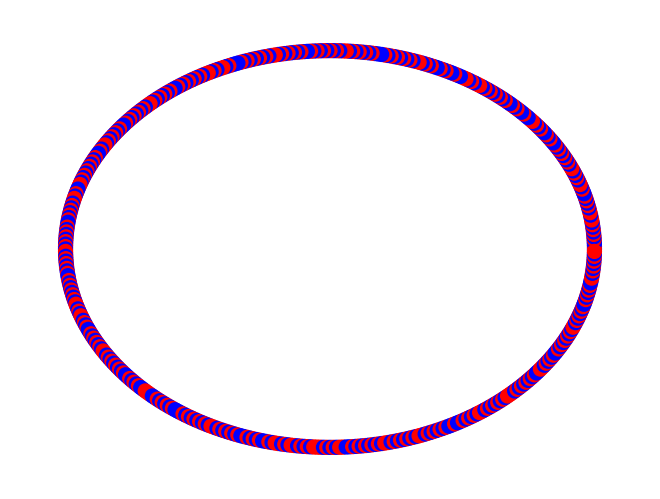

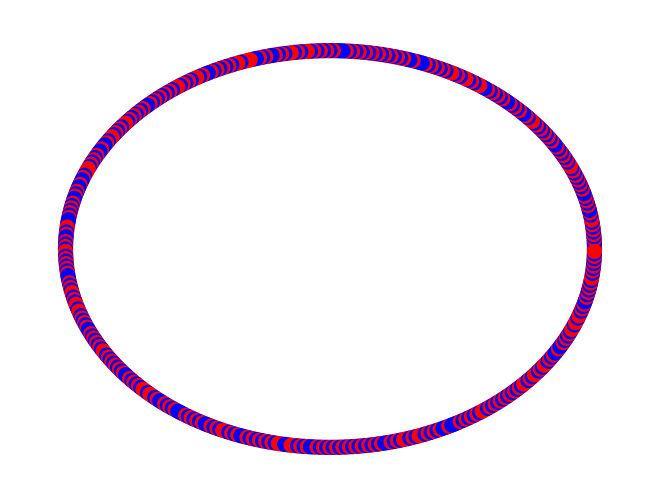

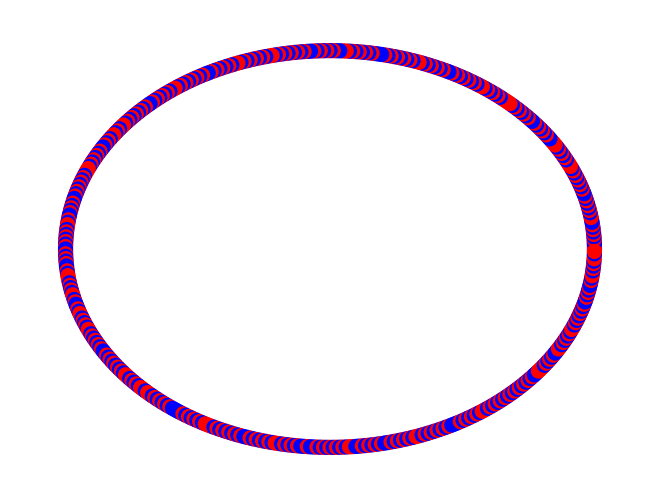

In [10]:
long_chain = anneal_1d_chain(0.01, N, 0.5)
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(0.1, N, 0.5)
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(1, N, 0.5)
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(10, N, 0.5)
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(100, N, 0.5)
spins = long_chain.record[0][0]
draw_chain(N, spins)

long_chain = anneal_1d_chain(1000, N, 0.5)
spins = long_chain.record[0][0]
draw_chain(N, spins)

Similarly there isn't much variation here.